# Supervised Learning 
The assignment set is expected to perform supervised learning. In this assignemnt linear regression, Gaussian process regression, and Neural Networks are implemented.

©Tomohiro Sasaki

## Import necessary libraries

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import random
from scipy.stats import multivariate_normal
from scipy.spatial.distance import pdist, cdist, squareform

# ML libraries for solution validation
import pandas as pd
from sklearn import svm
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ExpSineSquared
from sklearn.neural_network import MLPRegressor

import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
import copy

## Setup and helper functions

Before starting supervised learning, set up some useful functions

### Load CSV files



In [2]:
def load_csv(data_file_path, class_index=-1):
    """
    Load csv data in a numpy array.
    Args:
        data_file_path (str): path to data file.
        class_index (int): slice index for data labels.
    Returns:
        features, classes as numpy arrays if class_index is specified,
            otherwise all as nump array.
    """

    handle = open(data_file_path, 'r')
    contents = handle.read()
    handle.close()
    rows = contents.split('\n')
    
    out = np.array([[float(i) for i in r.split(',')] for r in rows[1:-1] if r])

    if(class_index == -1):
        classes= out[:,class_index]
        features = out[:,1:class_index]
        return features, classes
    elif(class_index == 0):
        classes= out[:, class_index]
        features = out[:, 1:]
        return features, classes

    else:
        return out

In [3]:
X, y= load_csv('./Dataset.csv',-1)

FileNotFoundError: [Errno 2] No such file or directory: './HW2Dataset.csv'

### Split dataset into training and testing sets

In [ ]:
def split_dataset(X, y, shuffle=True, train_size=1.):
    """
    Split dataset into training set and testing set
    Args: 
        X (n x m array): dataset
        y (float): label value
        shuffle (Bool): shuffle after splitting
        train_size (float): training set size
    Returns:
        X_train, X_test, y_train, y_test as numpy array
    """
    m = X.shape[0]

    m_train = int(train_size * m)
    
    ind_pool = [i for i in range(m)]
    test_ind_pool = [i for i in range(m)]
    
    X_train = []
    y_train = []
    train_ind_pool = []
    
    if shuffle:
        random.shuffle(ind_pool)
    
    while len(X_train) < m_train:
        ind = ind_pool.pop()
        X_train.append(X[ind])
        y_train.append(y[ind])
        train_ind_pool.append(ind)
        test_ind_pool.remove(ind)
    
    X_test = np.array([X[i] for i in test_ind_pool])
    y_test = np.array([y[i] for i in test_ind_pool])
    X_train = np.array(X_train)
    y_train = np.array(y_train)


    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = split_dataset(X, y, shuffle=True, train_size=.5)

### Cross-validation

To achieve a better fitted model of linear regression, we take a model validation technique called cross-validation.

Here is the cross-validation step:
1. Split the full dataset into a training set and a test set
2. Split the training set into $k$ subsets
3. For each of $k$ subsets
   1. train a model using $k-1$ subsets
   2. Compute the model error using the $k$ th subset
4. Compare errors from Step 2. to errors computed using the full dataset
5. If cross-validation errors are acceptable, build a model using the full training set
6. Evaluate model error on the unsceen test set


Cross-validation process is applied when Scikit-learn is used.
***

# Linear Regression

(Multivariate) Linear regression is 

Basic equation is
$$
y = f(x) + \varepsilon\\
f(x) =  \sum_{i=0}^{m} x_{i} \quad {\mathrm{where} ~x_0 = 1}
$$
Problem formulation is
$$

\min \mathrm{L S E} =\min \|{y}-{X} {w}\|_{2}^{2}=\min \sum_{n=1}^{N}\left[y^{(n)}-\left(\sum_{d=1}^{D} w_{d} X_{d}^{(n)}\right)\right]^{2}
\\
\mathrm{where}~{y}=\left[\begin{array}{c}y^{(1)} \\ y^{(2)} \\ \vdots \\ y^{(N)}\end{array}\right] \quad {X}=\left[\begin{array}{ccccc}1 & X_{1}^{(1)} & X_{2}^{(1)} & \ldots & X_{D}^{(1)} \\ 1 & X_{1}^{(2)} & X_{2}^{(2)} & \ldots & X_{D}^{(2)} \\ \vdots & \vdots & \vdots & \ddots & \vdots \\ 1 & X_{1}^{(N)} & X_{2}^{(N)} & \ldots & X_{D}^{(N)}\end{array}\right] \quad {w}=\left[\begin{array}{c}w_{0} \\ w_{1} \\ w_{2} \\ \vdots \\ w_{D}\end{array}\right]
$$

Since this problem is a well-defined quadratic minimization problem, there is analytical solution if $X^\mathrm{T}X$ exists.

$$
\|y - Xw\|^2_2 = y^{\mathrm T} y - 2 y^{\mathrm T} Xw + w^{\mathrm T } X^{\mathrm T} Xw 
$$
Take the derivative with respect to the weight $w$, then we have the following:
$$
\begin{aligned}
\nabla_w  \|y - Xw\|^2_2 &= \nabla_w \left [y^{\mathrm T} y - 2 y^{\mathrm T} Xw + w^{\mathrm T } X^{\mathrm T} Xw \right] \\
&= -2 X^{\mathrm T} (y - Xw) = 0
\end{aligned}
$$
Assuming $\mathrm{rank}~X^{\mathrm T}X = m$, then the solution of the minimization problem is:
$$
\hat{w} = (X^\mathrm{T} X)^{-1} X^{\mathrm T} y
$$

## Linear Regression without regularization 

In linear regression without regularization model is directly fitted the solution we have ($\hat{w} = (X^\mathrm{T} X)^{-1} X^{\mathrm T} y$).

In [55]:
class LinearReg():
    """ Class for Linear Regression without regularization """
    def __init__(self):
        self._is_invertible = False
        self._w = None
        self._is_fitted = False

    def fit(self, X, y):
        """
        model fitting
        """
        if np.linalg.matrix_rank(X.T @ X) == X.shape[1]:
            self._is_invertible = True
        if self._is_invertible:
            H = np.ones((X.shape[0], X.shape[1]+1))
            H[:,1:] = X
            self._w = np.linalg.inv(H.T @ H) @ H.T @ y
            self._is_fitted = True
        else:
            print("No solution exists or there exits infinite number of solution")
            return None

    def model(self, x):
        """
        computes the value of f(x)
        """
        w = self._w
        f = w[0]
        for i in range(len(x)):
            f += w[i+1] * x[i]
        return f

    def predict(self, X):
        """
        predict the value of y using model and input dataset
        """
        if self._is_fitted:
            y = []
            for x in X:
                y.append(self.model(x))
            return np.array(y)
        else:
            print("model is not fitted")

    def mean_squared_error(self, y_test, y_pred):
        """
        computes mean squared error
        """

        return np.sum((y_test - y_pred)**2)/len(y_test)
    
    def r2_score(self, y_test, y_pred):
        """
        computes R squared score
        """
        
        return 1 - self.mean_squared_error(y_test, y_pred)/(np.sum((y_test - np.mean(y_pred))**2))*len(y_test)
        
    

Fit the linear regression model,  predict values, and measure the performance

Model fitting is validated through Cross-validation process

In [56]:
LR = LinearReg()
LR.fit(X_train, y_train)
y_train_pred = LR.predict(X_train)
MSE_train = LR.mean_squared_error(y_train, y_train_pred)
R2_train = LR.r2_score(y_train, y_train_pred)

y_test_pred = LR.predict(X_test)
MSE_test = LR.mean_squared_error(y_test, y_test_pred)
R2_test = LR.r2_score(y_test, y_test_pred)

print("Train prediction mean squared error is ", MSE_train)
print("Train prediction R squared score is ", R2_train)

print("Test prediction mean squared error is ", MSE_test)
print("Test prediction R squared score is ", R2_test)

Train prediction mean squared error is  65.1885936335363
Train prediction R squared score is  0.8814199494517564
Test prediction mean squared error is  62.25722386474444
Test prediction R squared score is  0.8795291487490047


## Linear Regression with regularization

### Ridge Regression

Problem formulation for Ridge Regression is
$$

\min \|{y}-{X} {w}\|_{2}^{2} + \alpha \|w\|_2^2

$$

Since this problem is a well-defined quadratic minimization problem, there is analytical solution if $X^\mathrm{T}X$ exists.

The solution of the minimization problem is:
$$
\hat{w} = (X^\mathrm{T} X + \alpha I)^{-1} X^{\mathrm T} y
$$

In [57]:
class RidgeReg():
    """ Class for Ridge Regression """
    def __init__(self, alpha=0.01):
        self._is_invertible = False
        self._w = None
        self._is_fitted = False
        self._alpha = alpha
    def fit(self, X, y):
        """
        model fitting
        """
        if np.linalg.matrix_rank(X.T @ X) == X.shape[1]:
            self._is_invertible = True
        if self._is_invertible:
            H = np.ones((X.shape[0], X.shape[1]+1))
            H[:,1:] = X
            self._w = np.linalg.inv(H.T @ H + self._alpha * np.eye(H.shape[1])) @ H.T @ y
            self._is_fitted = True
        else:
            print("No solution exists or there exits infinite number of solution")
            return None

    def model(self, x):
        """
        computes the value of f(x)
        """
        w = self._w
        f = w[0]
        for i in range(len(x)):
            f += w[i+1] * x[i]
        return f

    def predict(self, X):
        """
        predict the value of y using model and input dataset
        """
        if self._is_fitted:
            y = []
            for x in X:
                y.append(self.model(x))
            return np.array(y)
        else:
            print("model is not fitted")

    def mean_squared_error(self, y_test, y_pred):
        """
        computes mean squared error
        """

        return np.sum((y_test - y_pred)**2)/len(y_test)
    
    def r2_score(self, y_test, y_pred):
        """
        computes R squared score
        """
        
        return 1 - self.mean_squared_error(y_test, y_pred)/(np.sum((y_test - np.mean(y_pred))**2))*len(y_test)
        
    

Fit the Ridge regression model,  predict values, and measure the performance

In [58]:
RR= RidgeReg(alpha=0.5)
RR.fit(X_train, y_train)

y_train_pred = RR.predict(X_train)
MSE_train = RR.mean_squared_error(y_train, y_train_pred)
R2_train = RR.r2_score(y_train, y_train_pred)

y_test_pred = RR.predict(X_test)
MSE_test = RR.mean_squared_error(y_test, y_test_pred)
R2_test = RR.r2_score(y_test, y_test_pred)

print("Train prediction mean squared error is ", MSE_train)
print("Train prediction R squared score is ", R2_train)

print("Test prediction mean squared error is ", MSE_test)
print("Test prediction R squared score is ", R2_test)

Train prediction mean squared error is  65.18910139349973
Train prediction R squared score is  0.8814190290586765
Test prediction mean squared error is  62.2411845075563
Test prediction R squared score is  0.8795594519531477


### LASSO Regression

Problem formulation for LASSO Regression is
$$

\min \|{y}-{X} {w}\|_{2}^{2} + \alpha \|w\|_2^2

$$

Since this problem is a well-defined quadratic minimization problem, there is analytical solution if $X^\mathrm{T}X$ exists.

The solution of the minimization problem is:
$$
\hat{w} = (X^\mathrm{T} X + \alpha I)^{-1} X^{\mathrm T} y
$$

--
Ridge has the best score compared to linear and LASSO regressions.

## validate via scikit-learn

#### Fit the model

In [59]:
rr = Ridge(alpha=0.01)
rr.fit(X_train, y_train) 

pred_train_rr= rr.predict(X_train)

print("Training MSE is", mean_squared_error(y_train,pred_train_rr))
print("Training R2 score is ",r2_score(y_train, pred_train_rr))

pred_test_rr= rr.predict(X_test)
print("Testing MSE is", mean_squared_error(y_test,pred_test_rr))
print("Testing R2 score is ", r2_score(y_test, pred_test_rr))

Training MSE is 65.18859383360724
Training R2 score is  0.8814199490878212
Testing MSE is 62.25695238649217
Testing R2 score is  0.8794944427357075


## Cross-validation with Ridge Regression

In [70]:
scores = cross_val_score(rr, X_train, y_train, scoring='r2', cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.88 accuracy with a standard deviation of 0.00


***

# Gaussian Process Regression

Gaussian process regression is a flexible class of nonparametric machine learning model commonly used for model spatial and time series data. The definition of gaussian process is the following: A Gaussian process is a collection of random variables, any finite number of which have a joint Gaussian distribution. We write the gaussian process in math as
$$
f(x) \sim \mathcal{G P}\left(m(\mathbf{x}), k\left(\mathbf{x}, \mathbf{x}^{\prime}\right)\right)
$$
where $m(\cdot)$ is the mean function and $k(\cdot,\cdot)$ is the covariance function.

Predictions for test points $f_*$ for given trainting points $f$ requires a multivariate conditional density given as
$$
p(f_*|f) = \mathcal{N} (\mu,\Sigma)
$$

In this assignment we use the exponential quadratic covariance function as an example. The covariance function specifies the covariance between pairs of random variables
$$
\operatorname{cov}\left(f\left(\mathbf{x}_{i}\right), f\left(\mathbf{x}_{j}\right)\right)=k\left(\mathbf{x}_{i}, \mathbf{x}_{j}\right)=\exp \left(-\frac{1}{2}\left \|\mathbf{x}_{i}-\mathbf{x}_{j}\right\|_2^{2}\right)
$$

In [61]:
from scipy.linalg import cholesky, cho_solve, solve_triangular

class GausProcReg():
    """ Class for Linear Regression without regularization """
    def __init__(self, alpha=1e-5, ell=None, normalize_y=True):
        self.alpha = alpha
        self.ell = ell
        self.normalize_y = normalize_y


    def kernel(self, X, Y=None, kernel="RBF"):
        """ 
        Define a covariance function, kernel function
        """
        alpha =  self.alpha
        ell = self.ell
        if ell == None:
            ell = len(X)
        
        if kernel == "RBF":
            # return alpha*np.exp(-0.5*(np.linalg.norm(x1-x2)/ell)**2)
            X = np.atleast_2d(X)
        
            if Y is None:
                dists = pdist(X, metric="sqeuclidean")
                K = np.exp(-0.5 * dists)
                # convert from upper-triangular matrix to square matrix
                K = squareform(K)
                np.fill_diagonal(K, 1)
            else:
                dists = cdist(X, Y, metric="sqeuclidean")
                K = np.exp(-0.5 * dists)
            return K


    def fit(self, X, y, y_std=None):
        """
        model fitting
        """
        
        if self.normalize_y:
            self._y_train_mean = np.mean(y, axis=0)
            self._y_train_std = np.std(y, axis=0)
            y = (y - self._y_train_mean) / self._y_train_std
        else:
            shape_y_stats = (y.shape[1],) if y.ndim == 2 else 1
            self._y_train_mean = np.zeros(shape=shape_y_stats)
            self._y_train_std = np.ones(shape=shape_y_stats)

        Kff = self.kernel(X)

        self.X_train_ = np.copy(X)
        self.y_train_ = np.copy(y) 

        try:
            self.L_ = cholesky(Kff, lower=True, check_finite=False)
        except np.linalg.LinAlgError as exc:
            exc.args = (
                "K matrix is not positive definite") 
            raise
        
        self.alpha_ = cho_solve(
            (self.L_, True),
            self.y_train_,
            check_finite=False,
        )


    def predict(self, X):
        """
        predict the value of y using model and input dataset
        """
        if self.alpha_ is not None:
            m = len(X)
            Ksf = self.kernel(X, self.X_train_)
            # compute posterior mean
            y_mean = Ksf @ self.alpha_

            # undo normalization
            y_mean = self._y_train_std * y_mean + self._y_train_mean
            
            V = solve_triangular(
                self.L_, Ksf.T, lower=True, check_finite=False
            )

            Kss = self.kernel(X)

            # compute posterior covariance
            y_cov = np.zeros((m,m))
            y_cov = Kss - V.T @ V

            # undo normalisation
            y_cov = np.outer(y_cov, self._y_train_std**2).reshape(*y_cov.shape, -1)

            if y_cov.shape[2] == 1:
                y_cov = np.squeeze(y_cov, axis=2)

            # compute log likelihood (not always necessary)
            # log_like = -1/2 * y @ np.linalg.inv(Kff + sigma**2 * np.eye(m)) @ y \
            #         -1/2 * np.log(np.linalg.det(Kff + sigma**2 * np.eye(m))) \
            #         - m/2 * np.log(2 * np.pi) 

            return y_mean, y_cov
        else:
            print("model is not fitted")

    def mean_squared_error(self, y_test, y_pred):
        """
        computes mean squared error
        """

        return np.sum((y_test - y_pred)**2)/len(y_test)
    
    def r2_score(self, y_test, y_pred):
        """
        computes R squared score
        """
        
        return 1 - self.mean_squared_error(y_test, y_pred)/(np.sum((y_test - np.mean(y_pred))**2))*len(y_test)

    

In [63]:
GPR= GausProcReg(alpha=1e-6, ell=1.,normalize_y=False)
GPR.fit(X_train, y_train)

y_train_mean, y_train_cov = GPR.predict(X_train)

MSE_train = GPR.mean_squared_error(y_train, y_train_mean)
# R2_train = GPR.r2_score(y_train, y_train_pred)

y_test_mean, y_test_cov = GPR.predict(X_test)
MSE_test = GPR.mean_squared_error(y_test, y_test_mean)
R2_test = GPR.r2_score(y_test, y_test_mean)

print("Train prediction mean squared error is ", MSE_train)
print("Train prediction R squared score is ", R2_train)

print("Test prediction mean squared error is ", MSE_test)
print("Test prediction R squared score is ", R2_test)


Train prediction mean squared error is  7.082123115282065e-26
Train prediction R squared score is  0.8814190290586765
Test prediction mean squared error is  32.10426073921217
Test prediction R squared score is  0.9382362916233387


### Scikit-learn validation (Compare self-made Gaussian Process Regression with Scikit-learn)

In [94]:
# Construction of Sklearn's Regression and Selection of the Kernel
# kernel = RBF()
# kernel = Matern()
kernel = RationalQuadratic()
gp_regressor = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True)
gp_regressor.fit(X_train, y_train)
print(f"Lengthscale: {gp_regressor.kernel_}")


Lengthscale: RationalQuadratic(alpha=0.0297, length_scale=4.33)


In [95]:
pred_train_gpr, y_pred_std = gp_regressor.predict(X_train, return_std=True)
pred_test_gpr, y_pred_std = gp_regressor.predict(X_test, return_std=True)

print("Training MSE is", mean_squared_error(y_train, pred_train_gpr))
print("Training R2 score is ",r2_score(y_train, pred_train_gpr))

print("Testing MSE is", mean_squared_error(y_test, pred_test_gpr))
print("Testing R2 score is ", r2_score(y_test, pred_test_gpr))

Training MSE is 3.890915468082337e-07
Training R2 score is  0.9999999992922306
Testing MSE is 4.86918999100871
Testing R2 score is  0.9905751176246216


## Cross-validation

In [91]:
scores = cross_val_score(gp_regressor, X_train, y_train, scoring='r2', cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.99 accuracy with a standard deviation of 0.00


***

# Neural Networks (No self-made class)

##  Scikit-learn

In [114]:
nn_regressor = MLPRegressor(
    hidden_layer_sizes=(100,), 
    activation='relu',
    solver='adam', 
    batch_size='auto', 
    learning_rate='adaptive',
    learning_rate_init=0.001,
    random_state=1, 
    max_iter=1000)
nn_regressor.fit(X_train, y_train)

MLPRegressor(learning_rate='adaptive', max_iter=1000, random_state=1)

In [115]:
pred_train_nn = nn_regressor.predict(X_train)
pred_test_nn = nn_regressor.predict(X_test)

print("Training MSE is", mean_squared_error(y_train, pred_train_nn))
print("Training R2 score is ",r2_score(y_train, pred_train_nn))

print("Testing MSE is", mean_squared_error(y_test, pred_test_nn))
print("Testing R2 score is ", r2_score(y_test, pred_test_nn))

Training MSE is 3.318263556105546
Training R2 score is  0.9939639768511134
Testing MSE is 3.9648184253411642
Testing R2 score is  0.992325633756831


## Cross-validation (Neural Network)

In [116]:
scores = cross_val_score(nn_regressor, X_train, y_train, scoring='r2', cv=5)
print("%0.4f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.9921 accuracy with a standard deviation of 0.00


## Pytorch

MSE: 14.56


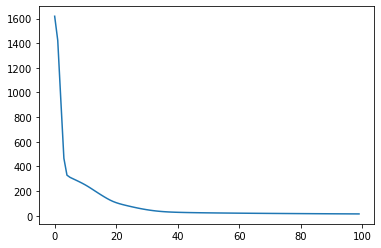

In [117]:
# Convert to 2D PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

# Define the model
model = nn.Sequential(
    nn.Linear(15, 30, bias=False),
    nn.ReLU(),
    nn.Linear(30, 10, bias=False),
    nn.ReLU(),
    nn.Linear(10, 4, bias=False),
    nn.ReLU(),
    nn.Linear(4, 1, bias=False)
)


# Define loss function and optimizer
loss_fn = nn.MSELoss() 
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Setup epochs and batch size
n_epochs = 100  
batch_size = 10  
batch_start = torch.arange(0, len(X_train), batch_size)


# learning setup
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]

            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)

            # backward pass
            optimizer.zero_grad()
            loss.backward()

            # update weights
            optimizer.step()

            # print progress
            bar.set_postfix(mse=float(loss))
            
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
 
# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
plt.plot(history)
plt.show()

